# Prepare data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [1]:
import unidecode
import string
import random
import re
import csv

all_characters = string.printable
n_characters = len(all_characters)

#file = unidecode.unidecode(open('./data/lyrics.txt', encoding='utf-8', errors='ignore').read())
file = ''
with open('./data/lyrics.txt', encoding='utf-8', errors='ignore') as read_file:
    for row in read_file:
        file += unidecode.unidecode(row[row.find(' ') + 1:])

file_val = file[-1000:]
file = file[:-1000]
file_len = len(file)
print('file_len =', file_len)

file_len = 2993531


To make inputs out of this big string of data, we will be splitting it into chunks.

In [2]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

def random_chunk_val():
    start_index = random.randint(0, len(file_val) - chunk_len)
    end_index = start_index + chunk_len + 1
    return file_val[start_index:end_index]

def nonsense_chunk():
    string = ''
    for _ in range(chunk_len):
        char_pos = random.randint(0, len(all_characters) - 1)
        string += all_characters[char_pos]
    return string

print(random_chunk())

G OF YOU 
I CAN'T BE TOO LATE TO SAY THAT I WAS 
ARE YOU FEELING IT TOO DOES THE FEELING SEEM OH SO RIGHT AND WHAT WOULD YOU SAY IF I CALLED ON YOU NOW 
OF LOVE WHAT AM I WITHOUT YOU I CAN'T BE TOO LAT


# Build the Model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

# Inputs and Targets

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [4]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [5]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

def random_val_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [41]:
import math
def evaluate(prime_str='A', prime_str_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(prime_str_len):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    sum_of_log = 0
    
    for p in range(prime_str_len, len(prime_str) - 1):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        normalized_outpus_dist = output_dist / output_dist.sum()
        char_pos = all_characters.index(prime_str[p + 1])
        sum_of_log += math.log(normalized_outpus_dist[char_pos])
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)
    
    perplexity = sum_of_log * (-1) / (len(prime_str))
    return predicted, perplexity

# Training

A helper to print the amount of time passed:

In [7]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [8]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

Then we define the training parameters, instantiate the model, and start training:

In [9]:
n_epochs = 5000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 2
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100)[0], '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 36s (100 2%) 2.0823]
Wh BUT'EL CACAF THE WHOT HOW KDE HER 
TE BUWSER WTHY 
INT NO'W THAY AK I THIRP WAY HER OF OUT FUERE 
W 

 15s (200 4%) 1.9364]
Wh TOL THE MAKE I'S YOU LAY IN THE MAKE GHAT THAT TRAPE TRNET MAKE HIDED YOU POVER I THE I'VER NEAW I  

 54s (300 6%) 1.8798]
Wh IN YOU 
LOVE SO IN HEFRE AND I WHAT WHERONG AND DENING 
I'D'S 
TO LROM LET NOKED 
AND TELL 
IN'T FI 

 31s (400 8%) 1.4577]
Wh YEAH YOU RERETIR LIKE CME TELL WE'RE SEE IS BUT 
YOU CHE POOME AND THIGHT THIS THE THE CUZ THIS YOU 

 8s (500 10%) 1.8512]
Wh YOUR I TO HEE'S I TO BE THE THE BE ALIKE THIS 
YOU I'M HER POY YOUR AND COSE CIM AND BUT I'VE MAME  

 46s (600 12%) 1.5879]
Wh YOUR HOW ME HEART I CAN'T ME STACKING YOUR LET I GO AND YOUR LET A FIVE OUT YOUR HEART WAS THERE I  

 23s (700 14%) 1.5579]
Wh WO THAT STARTING SID MARASS THE MEARS I WAY TELL AND BABY I CAN LAS I LOVE AND OW AND LAVE I WONG B 

 2s (800 16%) 1.9602]
Wh RIGFORM AND SORMIBE JUST I WAS RUN'T ME WHIS THE HEARD REALL HAS AWAYS AND WHERING W

# Plotting the Training Losses

Plotting the historical loss from all_losses shows the network learning:

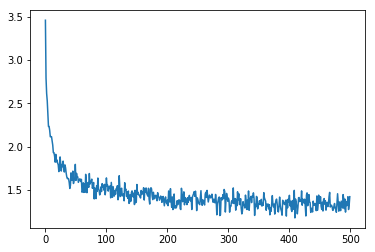

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Evaluating at different "temperatures"

In the `evaluate` function above, every time a prediction is made the outputs are divided by the "temperature" argument passed. Using a higher number makes all actions more equally likely, and thus gives us "more random" outputs. Using a lower value (less than 1) makes high probabilities contribute more. As we turn the temperature towards zero we are choosing only the most likely outputs.

We can see the effects of this by adjusting the `temperature` argument.

In [11]:
print(evaluate('YOU', 1000, temperature=0.8)[0])

YOUR LIFE AS ME SOMEBODY I DON'T SOMEBODY I'M HA'LL BREAK IT ME FEET AND MY LIVE IT TO ME FRIENDS 
YEAH YEAH 
I'D MY PLINE WANT YOU FEEL IT FLY 
THEY DON'T KNOW I'LL NEVER CAN BREAKING IN THE WRONG TO THE ARE 
MY LIFE ON A SEEMS AND I WANT YOUR FEAL LOVE YOU FELL TURN TOLUND I'LL KNOW I COULDN'T TO EVER HEART AND CHANGE 
LIFE'T THE GIRL 
LIFE FORG IN YOUR HADDED 
FINE EVERYTHING MY KNEED ME IN FOR MY RIGHT I COULD HER HAD BAD SO I WANT YOUR HEAR THEY TROUBLE BE THE GROUND IN AND 
OPE OFF TAKE TELL MY ELANE CLAP 
I WILL TELL THE SMELL 
I DID IN FLY FIEVES IN MY BODY IF YEAH YEAH NEED TO TO BE CRACKS WHEN YOUR EM RIGHT NOW I THOUGHT 
YEAR EVERYTHING AFTER MES I COULD PLEASE FOR YOUR HELL NEVER BELIEVE IT BUT I NEVER LET OF LEAGE 
CUT FOR CRANG BUT I WANNA DELLY I KNOW DEELCE YOU'LL FREST DON'T SEE 
OF YOU SAY YOU SHOT HIDE IN THE NEW OTHER FRIEND FOR CHER I LIEP AND FIVE THIS WAY TOLD BEFORE IT NOT OFF THERE 
I'M LOVE FOR HIDE YOUR THINGS I 
I'M CHANG FIND YOUR EYEST OH I'M ON LIKE A PRO

Lower temperatures are less varied, choosing only the more probable outputs:

In [12]:
print(evaluate('YOU', 1000, temperature=0.2)[0])

YOU DON'T MEAN YOU DON'T KNOW I WANNA FINE FIX YOUR HEART AND I WANNA BE A BREAK IT COME CLOSE THE FIRE FINE THIS WAY I WANNA BE A GOOD BUT I COULD BE THE FIRE TO MAKE YOU FEEL LIKE A FRIEND IT FINE THE FIRE THAT YOU FEEL LIKE THIS WAY TO THE FIRE COME TO THE FIRE CLOSE THE FIRE THE FIRE CLOOLING TO THE FIRE FOOL THE FIRE COME TO COME AND I CAN BREAK IT TO THE FIRE THE FIRE IT TO LOVE YOU KNOW I WANT YOUR HEART AND I'M SOMEBODY I WANT YOUR BEEN IN THE FIRE CLOSE THE FIRE COME TO THE FIRE LIKE THIS WAY TO THE FIRE CLOSE IT AND I'M LIKE THE WAY YOU CAN FLY I DON'T KNOW WHO HEAD I DON'T THE FIRE FINE I DON'T KNOW WHAT YOU CAN BE THE FIRE COME TO ME AND I WANT YOUR BEEN IN THE FIRE FIRE CHANGE IF I CAN BE AND THE FIRE IT IN THE FIRE FINE THE LIFE HOW THE FIRE THE WORLD I DON'T KNOW I WANNA FEEL THE SEA TO MAKE IT IN THE FIRE FINE FOR YOU FEEL LIKE A FRIEND IT TO THE FIRE TO MAKE IT IN THE FIRE FINE YOU AND I'M LOVE YOU GOT TO THE FIRE FOR YOU DON'T KNOW YOU AND I WANNA FEEL LIE COULD BE AN

Higher temperatures more varied, choosing less probable outputs:

In [13]:
print(evaluate('YOU', 1000, temperature=1.4)[0])

YOURD FELKS IT IN I FEEL FLINING ULCOLCLOX ALWAY EVEN BORN TO GOODBECIS FALLING'S JAN WHYAIR ARS TO FLY DIDNE
TECARESSISING HONE BOLD FLESS YOU AND EASY LOW WHY TALLY AND ALL THE PEOPLE SOMEBODY 
IS WHOUCSRNIABLEED 
ME IN MY I DONUBL TRYING TOLD TELL 
BEAUTIFUL A FORMS TO MINEMER IT IN I HANIFUN OW WROND OURLAZZY NABOLY AND 
NO IDONKITITIL IT NOT JOMY YOUR FARPLASHED MY HANNS TOLD BEST AINNA HEART SOULW IN CONTHER WORDS AROUND AND TIFFFED I NIMJ TO US CRY US DOWN'T HOME 
THE DIRE THAT I KNWO FILL YOU WIKER I WANNA FFELLSPECTIITE CAN THER ITN NA LRINE YEEA"NTIDG WITKES BURN BORN TRIED TO SRNAIGHT I THINTS TO BETEVER DAY I'LL SAIDN'T GIVISSING IT PAUS AND TOPRING'S 
LAGEASICAN AND I'LL GIRLLING WHENE 
MY AND DOLDET STOP PEQOUGUH HITCR TO IF I FELL IN ME AND TOTLIGOT CLOLD 
LET YOU WE LOMING BIGUS SHE HAPDOTTERGY TOFFY A RRILITAIRING I'D GOUT I'M CLAND A QUE THE I'VE AINNING BADINSNETHER REHLS CUZING WANTOUS STAY KNOW FEY FRRRGIEVER FOR IT AND THE FEART MUNY 
IF A DEEEFLE
LIE I KNOW CHEAS

# perplexity

In [42]:
prime_str_len = 100
train_data_str = random_chunk()
val_data_str = random_chunk_val()[:-1]
random_str = nonsense_chunk()

In [43]:
predicted, perplexity = evaluate(train_data_str, prime_str_len, temperature=0.8)
perplexity

3.6023459094834127

In [44]:
predicted, perplexity = evaluate(val_data_str, prime_str_len, temperature=0.8)
perplexity

4.140773127271072

In [45]:
predicted, perplexity = evaluate(random_str, prime_str_len, temperature=0.8)
perplexity

9.115670415785104